# Another example
EMIT_L1B_RAD_001_20240427T165527_2411811_009

In [1]:
import hyperquest

from spectral import *
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
import numpy as np

In [2]:
# Define path to EMIT surface reflectance
path_to_data = '../tests/data/EMIT_L1B_RAD_001_20240427T165527_2411811_009.nc'

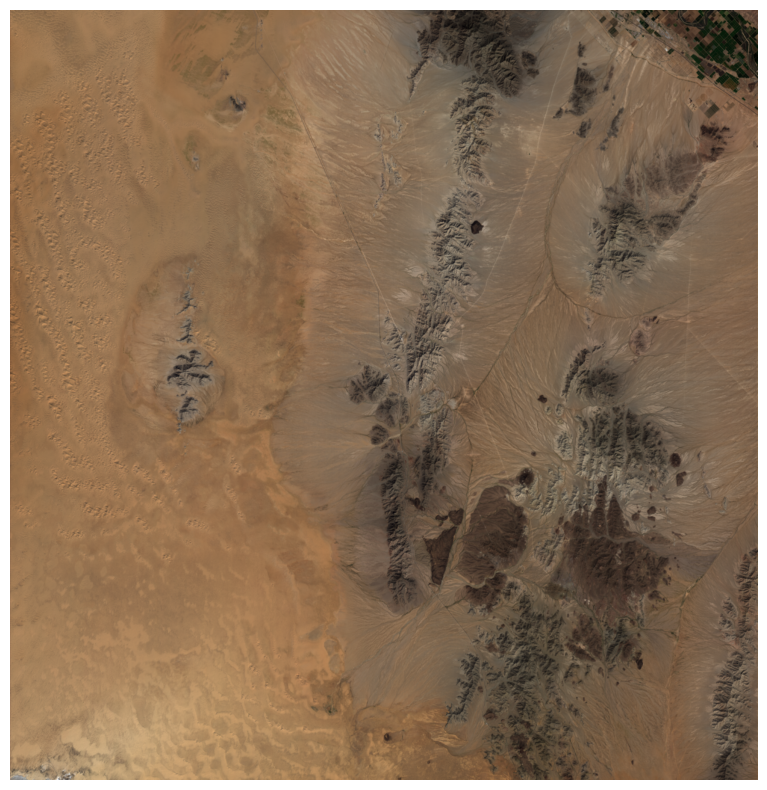

In [3]:
# Load raster
array, fwhm, wave, obs_time = hyperquest.retrieve_data_from_nc(path_to_data)
red = array[:,:,38]
blue = array[:,:,11]
green = array[:,:,24]

red= np.ma.masked_equal(red, -9999)
green = np.ma.masked_equal(green, -9999)
blue = np.ma.masked_equal(blue, -9999)

# Normalize the values for display
plt.figure(figsize=(10, 10))
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-70.00578705601649..62.068040583872545].


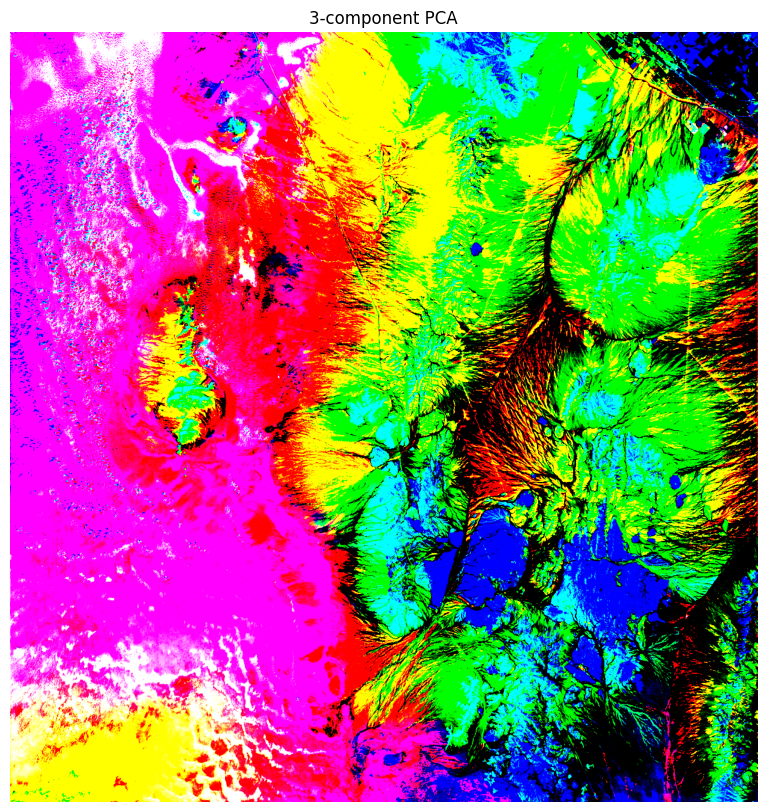

In [4]:
# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array[np.isnan(array)] = -9999
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
n_segments = 10000
compactness = 0.5


segments = slic(array_pca, 
                n_segments=n_segments, 
                compactness=compactness)


plt.figure(figsize=(10, 10))
plt.imshow(array_pca)
plt.title("3-component PCA")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-70.00578705601649..62.068040583872545].


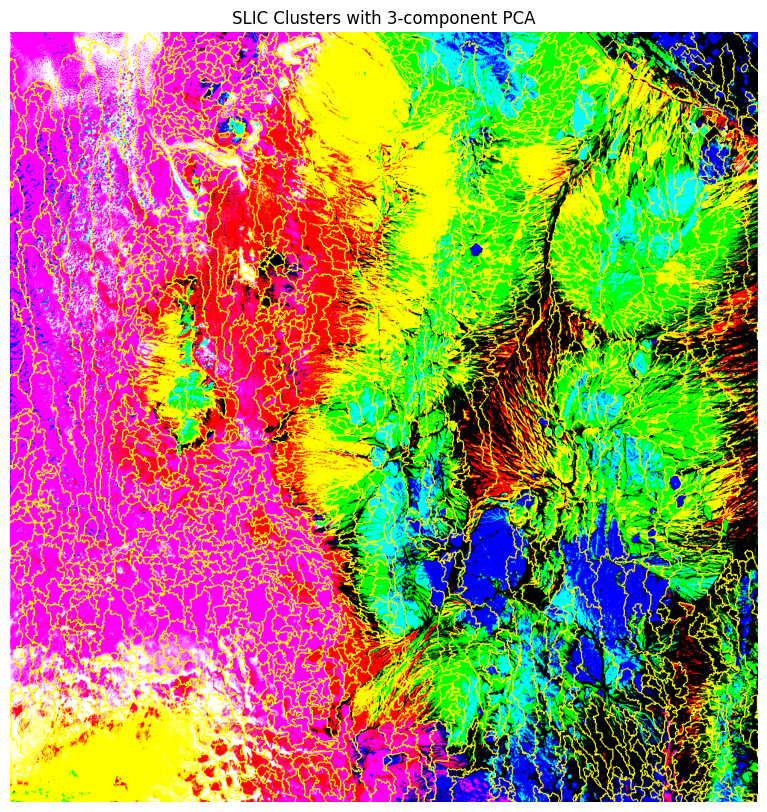

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(array_pca, segments))
plt.title("SLIC Clusters with 3-component PCA")
plt.axis("off")
plt.show()

In [6]:
snr, noise_variance = hyperquest.hrdsdc(path_to_data, n_segments, compactness, 
                                        n_pca=3, ncpus=8,
                                        no_data_value=-9999)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


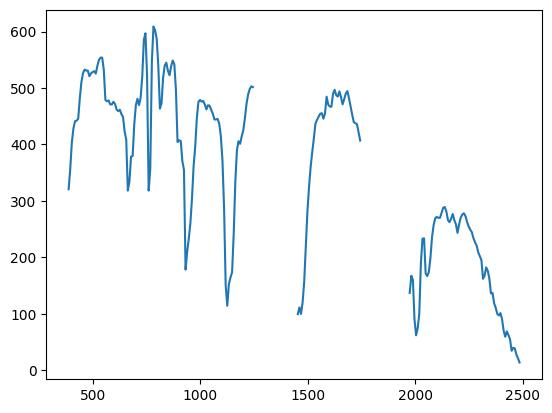

In [9]:
import matplotlib.pyplot as plt
plt.plot(wave, snr)
plt.show()

In [10]:
k_eff = hyperquest.random_matrix_theory(path_to_data = path_to_data,
                                        noise_variance = noise_variance,
                                        alpha = 0.5,
                                        no_data_value = -9999)

In [11]:
k_eff

41

### K-eff=41 is probably too large given this image (?).
TODO: assess method of Asad Mahmood et al., https://ieeexplore.ieee.org/abstract/document/8077550 for correlated noise. Methods like this will bring down the k-eff values.